In [3]:
#import rospy
#from styx_msgs.msg import TrafficLight
import tensorflow as tf
import numpy as np
import cv2
from PIL import Image
from PIL import ImageDraw
from PIL import ImageColor
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from keras.models import load_model
import glob

/Users/azheng/anaconda3/envs/carnd-term1/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/azheng/anaconda3/envs/carnd-term1/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
Using TensorFlow backend.
/Users/azheng/anaconda3/envs/carnd-term1/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/azheng/anaconda3/envs/carnd-term1/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [4]:
class GraphDetection():

    def __init__(self):
        self.detection_graph = self.load_graph('light_classification/model_detection.pb')        
        self.image_tensor = self.detection_graph.get_tensor_by_name('image_tensor:0')
        self.detection_boxes = self.detection_graph.get_tensor_by_name('detection_boxes:0')
        self.detection_scores = self.detection_graph.get_tensor_by_name('detection_scores:0')
        self.detection_classes = self.detection_graph.get_tensor_by_name('detection_classes:0')
        self.detection_number = self.detection_graph.get_tensor_by_name('num_detections:0')
        self.sess = tf.Session(graph=self.detection_graph)

    def run(self, image):

        # Actual detection.
        (boxes, scores, classes, num) = self.sess.run([self.detection_boxes, self.detection_scores, self.detection_classes, self.detection_number], 
                                        feed_dict={self.image_tensor: image})
        # Remove unnecessary dimensions
        boxes = np.squeeze(boxes)
        scores = np.squeeze(scores)
        classes = np.squeeze(classes)

        # Filter boxes with a confidence score less than `CONFIDENCE_CUTOFF`
        return self.filter_boxes(0.05, boxes, scores, classes)

    def filter_boxes(self, min_score, boxes, scores, classes):
        """Return boxes with a confidence >= `min_score` and class == 10 (traffic light)""" 
        n = len(classes)
        idxs = []
        for i in range(n):
            if scores[i] >= min_score and classes[i] == 10:
                idxs.append(i)
    
        filtered_boxes = boxes[idxs, ...]
        filtered_scores = scores[idxs, ...]
        filtered_classes = classes[idxs, ...]
        return filtered_boxes, filtered_scores, filtered_classes

    def load_graph(self, graph_file):
        """Loads a frozen inference graph"""
        graph = tf.Graph()
        with graph.as_default():
            od_graph_def = tf.GraphDef()
            with tf.gfile.GFile(graph_file, 'rb') as fid:
                serialized_graph = fid.read()
                od_graph_def.ParseFromString(serialized_graph)
                tf.import_graph_def(od_graph_def, name='')
        return graph

In [32]:
class TLClassifier(object):


    def __init__(self):
        self.classifier = load_model('classifier_carla.h5')
        self.detection = GraphDetection()     
        
    def get_classification(self, image):

        img_expanded = np.expand_dims(np.asarray(image, dtype=np.uint8), 0) 
        
        # Get boxes for traffic lights
        boxes, scores, classes = self.get_boxes_for_traffic_lights(img_expanded)

        height, width, channels = image.shape
        
        box_coords = self.to_image_coords(boxes, height, width)

        for i in range(len(boxes)):
            ymin = int(box_coords[i][0])
            xmin = int(box_coords[i][1])
            ymax = int(box_coords[i][2])
            xmax = int(box_coords[i][3])
            
            image_a = np.asarray(image)
            cropped_image = image_a[max(ymin-20,0):min(ymax+20,height), max(xmin-20,0):min(xmax+20,width), :]
            image_resized = cv2.resize(cropped_image, (32, 32))

            image_resized = image_resized/255.0-0.5

            light_color = self.get_light_classification(image_resized, 32, 32, 3)

            if light_color == 0:
                return light_color             
        #rospy.loginfo('RED LIGHT DETECTED')

        #rospy.loginfo('UNKNOWN')
        return -1
    

    def get_boxes_for_traffic_lights(self, image):
        return self.detection.run(image)


    def get_light_classification(self, image, height, width, channels):
        predictions = self.classifier.predict(image.reshape((1, height, width, channels)))
        color =  predictions[0].tolist().index(np.max(predictions[0]))
        
        return color

    ################# Utils ########################    


    def to_image_coords(self, boxes, height, width):
        """
        The original box coordinate output is normalized, i.e [0, 1].
    
        This converts it back to the original coordinate based on the image size.
        """
        box_coords = np.zeros_like(boxes)    
        box_coords[:, 0] = boxes[:, 0] * height
        box_coords[:, 1] = boxes[:, 1] * width
        box_coords[:, 2] = boxes[:, 2] * height
        box_coords[:, 3] = boxes[:, 3] * width

        return box_coords

In [37]:
file = cv2.imread('red/frame001858.png')
file = cv2.cvtColor(file, cv2.COLOR_BGR2RGB);
#file = cv2.cvtColor(file, cv2.COLOR_BGR2RGB);
#resized = cv2.resize(file, (32,64))

#plt.imshow(file)


In [38]:
tl_classify = TLClassifier()        
color = tl_classify.get_classification(file)
color
#img
#img = cv2.cvtColor( np.uint8((img+0.5)*255), cv2.COLOR_RGB2BGR )
#plt.imshow(img)
#out = np.array(img*255, dtype=np.uint8)
#out = cv2.cvtColor(out, cv2.COLOR_RGB2BGR)
#cv2.imwrite('Green_test.jpg',out)


0

In [15]:
tl_detect = GraphDetection()

In [92]:
img_expanded = np.expand_dims(np.asarray(file, dtype=np.uint8), 0) 

In [143]:
img_expanded.shape

(1, 600, 800, 3)

In [94]:
boxes, scores, classes = tl_detect.run(img_expanded)

In [ ]:
for img_class, directory in enumerate(['red', 'yellow', 'green']):
    for i, file_name in enumerate(glob.glob("{}/*.png".format(directory))):
        file = cv2.imread(file_name)
        file = cv2.cvtColor(file, cv2.COLOR_BGR2RGB)
        tl_classify = TLClassifier(directory, file_name)        
        color = tl_classify.get_classification(file)

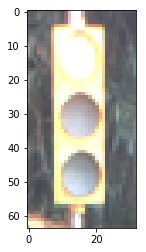